In [7]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random

(-0.5, 799.5, 639.5, -0.5)

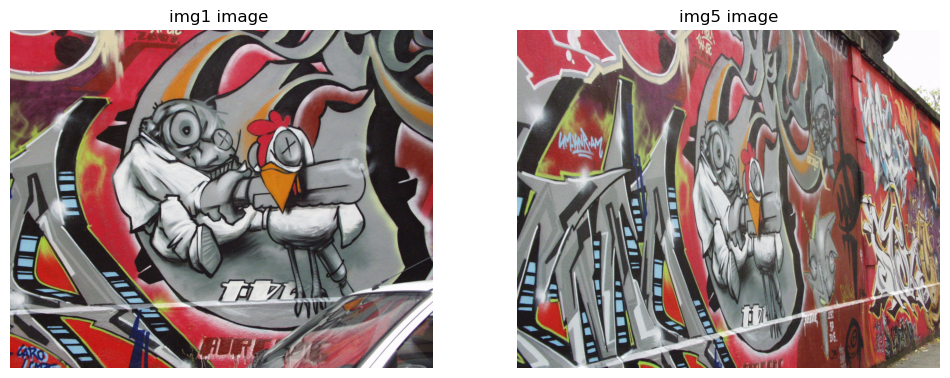

In [8]:
img1 = cv.imread('../../graf/img1.ppm')
img5 = cv.imread('../../graf/img5.ppm')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('img1 image ')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title('img5 image')
plt.axis('off')

In [9]:
# Convert to grayscale
gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
gray5 = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

# SIFT detector
sift = cv.SIFT_create()

# Find keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(gray1, None)
kp5, des5 = sift.detectAndCompute(gray5, None)

# Match descriptors using FLANN matcher
index_params = dict(algorithm=1, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des5, k=2)

# Apply ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

In [10]:
# Function to compute homography using DLT
def compute_homography(src_pts, dst_pts):
    A = []
    for i in range(len(src_pts)):
        x, y = src_pts[i][0], src_pts[i][1]
        x_prime, y_prime = dst_pts[i][0], dst_pts[i][1]
        A.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
        A.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])
    
    A = np.asarray(A)
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape((3, 3))
    return H / H[2, 2]  # Normalize the homography

# Function to apply homography and calculate inliers
def apply_homography(H, src_pts, dst_pts, threshold=5):
    inliers = []
    for i in range(len(src_pts)):
        src_pt = np.array([src_pts[i][0], src_pts[i][1], 1])
        projected = np.dot(H, src_pt)
        projected /= projected[2]  # Normalize

        dst_pt = np.array([dst_pts[i][0], dst_pts[i][1], 1])
        
        error = np.linalg.norm(dst_pt[:2] - projected[:2])
        if error < threshold:
            inliers.append(i)
    
    return inliers

# Function to run RANSAC to estimate the best homography
def ransac_homography(src_pts, dst_pts, iterations=1000, threshold=5):
    max_inliers = []
    best_H = None

    for _ in range(iterations):
        # Randomly select 4 points
        indices = random.sample(range(len(src_pts)), 4)
        src_sample = [src_pts[i] for i in indices]
        dst_sample = [dst_pts[i] for i in indices]
        
        # Compute homography for this random sample
        H = compute_homography(src_sample, dst_sample)
        
        # Find inliers
        inliers = apply_homography(H, src_pts, dst_pts, threshold)
        
        # Keep the homography with the most inliers
        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            best_H = H
    
    return best_H, max_inliers


In [11]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])
dst_pts = np.float32([kp5[m.trainIdx].pt for m in good_matches])

# Compute homography using our RANSAC implementation
H_ransac, inliers = ransac_homography(src_pts, dst_pts)

print("Homography using custom RANSAC:\n", H_ransac)

Homography using custom RANSAC:
 [[-6.50517259e-01 -4.17811984e-01  4.31919344e+02]
 [-5.26638346e-01 -3.37011163e-01  3.48900770e+02]
 [-1.50983381e-03 -9.65292250e-04  1.00000000e+00]]


(-0.5, 799.5, 639.5, -0.5)

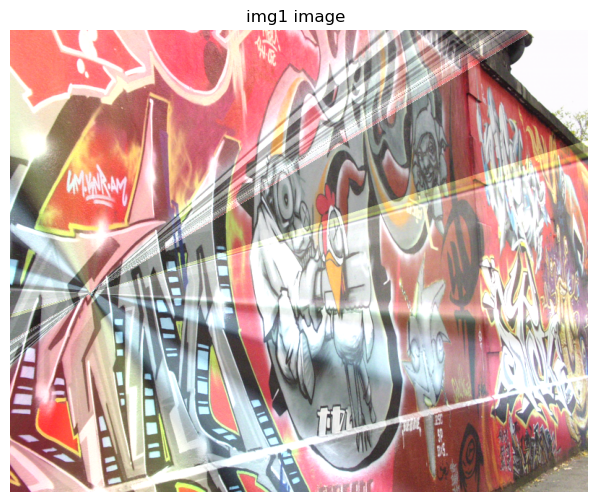

In [10]:
warped_img = cv.warpPerspective(img1, H, (img5.shape[1], img5.shape[0]))
result = cv.addWeighted(img5, 1, warped_img, 0.5, 0)

plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.title('img1 image ')
plt.axis('off')



